# Linear regression
Sîrbu Matei-Dan, _grupa 10LF383_

In [10]:
import numpy as np
import pandas as pd
from typing import Tuple, List

## Data reading

In [11]:
# incarcarea datelor

# data source: http://archive.ics.uci.edu/ml/datasets/Condition+Based+Maintenance+of+Naval+Propulsion+Plants
file = 'data.txt'
data_df = pd.read_csv(file, sep=r'\s+', header=None)
data = data_df.values

In [12]:
# se sterge penultima coloana

data1 = data[:, :-2]
data2 = data[:, -1].reshape((11934, 1))
data = np.c_[data1, data2]
print("First row: ", data[0, :])
assert data.shape == (11934, 17)

First row:  [1.138000e+00 3.000000e+00 2.899640e+02 1.349489e+03 6.677380e+03
 7.584000e+00 7.584000e+00 4.640060e+02 2.880000e+02 5.505630e+02
 1.096000e+00 9.980000e-01 5.947000e+00 1.019000e+00 7.137000e+00
 8.200000e-02 9.750000e-01]


## Input processing

In [13]:
# Functie pentru separarea datelor de intrare de cele de iesire

def get_input_output(mat: np.array) -> Tuple[np.array, np.array]:
    """Separa partea de intrare (variabile independente) de cea de iesire 
    (variabila dependenta).
    
    :param mat: np.array de forma (m, n). Fiecare linie este un caz 
    inregistrat, adica un vector de intrare. Primele n-1 coloane sunt valori 
    de intrare in model, ultima coloana este valoarea de iesire asociata 
    (ground truth).
    
    :return: un tuplu cu: matrice de (m, n-1) continand intrarile 
    (o linie = un vector de intrare); un vector coloana cu m linii continand
    valorile de iesire asociate intrarilor.
    """
    m, n = mat.shape
    X = mat[:, :-1]
    y = mat[:, -1].reshape(-1, 1)
    assert np.alltrue(X == mat[:, :-1])
    assert np.alltrue(y[:, -1] == mat[:, -1])
    return X, y

In [14]:
# separa matricea cu vectorii de intrare si vectorul coloana cu iesirile asociate

X, y = get_input_output(data)

In [15]:
# Functie pentru scalarea datelor in intervalul [0, 1]. 
# Scalele se calculeaza pe baza datelor furnizate

def scale_matrix(mat: np.array) -> np.array:
    """Preia o matrice cu valori reale si scaleaza toate coloanele in 
    intervalul [0, 1]. Coloanele constante vor fi transformate in 1.
    
    :param mat: matrice de forma (m, n)
    :return: matrice cu valori scalate in [0, 1]
    """
    
    # calculeaza pe ce indecsi minimele si maximele difera. 
    # Doar pe acestea se va face scalare. Coloanele pentru care minimele si 
    # maximele sunt egale au valori constante si vor fi umplute automat cu 1.
    
    # min_cols, max_cols = [mat[:,col].min() for col in range(0, np.size(mat,1))], [mat[:,col].max() for col in range(0, np.size(mat,1))]
    min_cols, max_cols = np.min(mat, axis=0), np.max(mat, axis=0)
    different_min_max = [col for col in range(0, np.size(mat,1)) if min_cols[col] != max_cols[col]]
    result = np.ones_like(mat)
    result[:, different_min_max] = [[(mat[i,j] - min_cols[j])/(max_cols[j] - min_cols[j]) for j in different_min_max] for i in range(0, np.size(mat, 0))]
    result.reshape(mat.shape)
    assert np.alltrue(np.min(result, axis=0) >= 0)
    assert np.alltrue(np.max(result, axis=0) <= 1)
    return result, min_cols, max_cols

In [16]:
# Functie pentru scalarea datelor. 
# Scalele sunt furnizate, de regula calculate pe baza datelor din setul 
# de antrenare

def scale_matrix_with_known_minmax(mat: np.array, min_cols: np.array, max_cols: np.array) -> np.array:
    """Preia o matrice  :param mat: si efectueaza scalarea valorilor in 
    intervalul [0, 1] folosind valori de min si max pe fiecare coloana 
    precalculate si date prin parametrii :param min_cols:, :param max_cols:.
    
    :param mat: matricea de (m, n) care trebuie scalata.
    :param min_cols: minime pe coloane, precalculate
    :param max_cols: maxime pe coloane, precalculate
    :return: matrice de (m, n) cu valori scalate.
    """
    # calculeaza pe ce indecsi minimele si maximele difera. 
    # Doar pe acestea se va face scalare. Coloanele pentru care minimele si 
    # maximele sunt egale au valori constante si vor fi umplute automat cu 1.
    
    different_min_max = [col for col in range(0, np.size(mat,1)) if min_cols[col] != max_cols[col]]
    result = np.ones_like(mat)
    result[:, different_min_max] = [[(mat[i,j] - min_cols[j])/(max_cols[j] - min_cols[j]) for j in different_min_max] for i in range(0, np.size(mat, 0))]
    assert result.shape == mat.shape
    return result

In [17]:
# scaleaza matricele

X, min_cols, max_cols = scale_matrix(X)
y, _, _ = scale_matrix(y)

In [18]:
# calculeaza matricea de design: coloana de 1 adaugata in fata datelor originare

def design_matrix(mat: np.array) -> np.array:
    """Preia o matrice de forma (m, n) si returneaza o matrice de forma 
    (m, n+1), in care prima coloana este 1, iar ultimele n coloane sunt 
    coloanele lui :param mat:.
    
    :param mat: matrice de forma (m, n)
    :return: matrice de forma (m, n+1), cu prima coloana plina cu 1, ultimele 
    n coloane sunt cele din :param mat:
    """
    m, n = mat.shape
    result = np.hstack((np.ones(m).reshape(m, 1), mat))
    assert result.shape == (m, n+1)
    assert np.alltrue(result[:, 0] == 1)
    assert np.alltrue(result[:, 1:] == mat)
    return result

In [19]:
# calculeaza matricea de design: vechea matrice la care se adauga pe prima
# pozitie coloana cu 1
X = design_matrix(X)

## Linear regression with stochastic gradient descent

### Model implementation

In [20]:
# Functie care implementeaza modelul de regresie liniara

def h(X: np.array, w: np.array) -> np.array:
    """Pentru un model liniar specificat prin parametrii w si un set de date 
    de intrare X produce valorile estimate de model: 
    y_hat[i] = X[i, 0] * w[0] + X[i, 1] * w[1] + ...  
   
   :param X: valori de intrare, structurate ca np.array de forma (m, n)
   :param w: vector de ponderi, de forma (n, 1)
   :return: vector cu valori de iesire estimate, de forma (n, 1). 
    """
    assert w.shape == (X.shape[1], 1)
    assert X.shape[1] == w.shape[0]
    y_hat = np.matmul(X, w)
    assert y_hat.shape == (X.shape[0], 1)
    return y_hat

### MSE function
$$MSE = \frac{1}{n} \sum_{i=1}^n (y^{(i)} - \hat{y}^{(i)})^2$$
unde $$\hat{y} = h_{\theta}(x)$$

In [21]:
# Implementare de eroare patratica medie

def mean_squared_error(y: np.array, y_hat: np.array) -> float:
    """Functie de eroare patratica medie.
    
    :param y: vector coloana de m elemente, continand valorile de iesire reale 
    (ground truth)
    :param y_hat': vector coloana de m elemente, continand valorile de iesire
    estimate.
    :return: eroarea patratica medie.
    """
    n = y.shape[0]
    result = 1/n * ((np.subtract(y, y_hat)**2).sum())
    return result

### Cost function
Look up: L2 regularisation
https://stats.stackexchange.com/questions/287920/regularisation-why-multiply-by-1-2m <br>
$\large J^+(\theta) = J(\theta) + \frac{\lambda}{2m} \sum_{j=1}^{n} \theta_j^2$ <br>
unde J: <br>
$\large J(\theta) = J(\theta_0, \theta_1) = \frac{1}{2m} \sum_{i=1}^{m} ((h_{\theta}(x^{(i)}) - y^{(i)})^2)$ <br>
_Documentație curs: pagina 21_

In [22]:
# Functia de eroare

def J(X:np.array, w:np.array, y:np.array, lmbda: float = 0) -> float:
    """Calculeaza valoarea functiei de eroare pentru intrarea curenta :param X:, 
    estimarea produsa de model folosind ponderile :param w: si iesirea corecta
    :param y: (ground truth).
    
    :param X: matrice de valori de intrare pentru care modelul de regresie 
    liniara produce estimari. Are forma (m, n)
    :param w: vector coloana de ponderi, definind coeficientii modelului de 
    regresie liniara. Are forma (n, 1).
    :param y: vector coloana de valori de iesire cunoscute (ground truth). 
    Are forma (n, 1).
    :param lmda: coeficientul de penalizare L2
    :return: jumatate din mean squared error plus penalizarea L2
    """
    
    assert w.shape == (X.shape[1], 1)
    assert y.shape == (X.shape[0], 1)
    assert lmbda >= 0
    m = X.shape[0]
    y_hat = h(X, w)
    assert y_hat.shape == (X.shape[0], 1)
    term_squared_error = 1/(2*m) * np.sum(np.subtract(y_hat, y)**2)
    l2_error = lmbda/(2*m) * np.sum(w**2)
    return term_squared_error + l2_error 

### Stochastic gradient descent implementation

Vector de gradienți (derivate parțiale): $\large \nabla_{\theta}J = \begin{pmatrix} \frac{\partial{J}}{\partial{\theta_0}} \\ \frac{\partial{J}}{\partial{\theta_1}} \end{pmatrix}$ 
, unde $\large \frac{\partial{J}}{\partial{\theta_j}} = \frac{1}{m} \sum_{i=1}^{m} [(h_\theta(x^{(i)}) - y^{(i)}) \cdot x_j^{(i)}]$ <br>
Gradient cu penalizare L2: $\large \frac{\partial{J}}{\partial{\theta_j}} = \frac{1}{m} \sum_{i=1}^{m} [(h_\theta(x^{(i)}) - y^{(i)}) \cdot x_j^{(i)}] + \frac{\lambda}{m} \theta_{j} \ \ \ \text{pentru } j \geq 1$
($\frac{\partial{J}}{\partial{\theta_0}}$ nu are penalizare L2)<br>
(Documentație: http://pingax.com/regularization-implementation-r/)<br><br>
Algoritm:  <br>
`Repeat {` <br>
$\large \theta_0 := \theta_0 - \alpha \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_0^{(i)}$ <br>
$\large \theta_j := \theta_j - \alpha [(\frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}) + \frac{\lambda}{m} \theta_j] \ \ \ \ j \in \{1, 2, ..., n\}$ <br>
`}`  <br>
(Documentație: https://stats.stackexchange.com/questions/111388/derivation-of-regularized-linear-regression-cost-function-per-coursera-machine-l)

In [23]:
# Calcul de gradient. gradientul se va folosi in actualizarea ponderilor. 

def gradient(X:np.array, w:np.array, y:np.array, lmbda: float = 0) -> np.array:
    """Calculeaza gradientul functiei de eroare
    
    :param X: matrice de valori de intrare pentru care modelul de regresie 
    liniara produce estimari. Are forma (m, n)
    :param w: vector coloana de ponderi, definind coeficientii modelului de 
    regresie liniara. Are forma (n, 1).
    :param y: vector coloana de valori de iesire cunoscute (ground truth). 
    Are forma (n, 1).
    :param lmda: coeficientul de penalizare L2
    :return: vector gradient
    """
    assert w.shape == (X.shape[1], 1)
    assert y.shape == (X.shape[0], 1)
    assert lmbda >= 0
    m, n = X.shape
    y_hat = h(X, w)
    sums = np.subtract(y_hat, y) # for i = 1 to m: y_hat[i] - y[i]
    sums = np.multiply(np.repeat(sums, repeats=n, axis=1), X) ## * X[i,j]
    grad = 1/m * np.vstack(np.sum(sums, axis=0)) ## 1/m * sum
    grad = grad + (lmbda/m)*w
    assert grad.shape == w.shape
    return grad

In [24]:
# Implementarea algoritmului de antrenare

def train(X:np.array, y:np.array, max_iters:int = 100000, alpha:float = 0.01, lmbda: float = 0.01) -> Tuple[np.array, List[float]]:
    """Aplica algoritmul de instruire cu gradient. 
    
    :param X: matrice de valori de intrare pentru care modelul de regresie 
    liniara produce estimari. Are forma (m, n)
    :param y: vector coloana de valori de iesire cunoscute (ground truth). 
    Are forma (n, 1).
    :param alpha: rata de invatare
    :param lmda: coeficientul de penalizare L2
    :return: tuplu continand ponderile modelului rezultate dupa instruire, lista de erori pe setul de antrenare
    """
    m, n = X.shape
    assert y.shape == (m, 1)
    assert X.shape[0] == y.shape[0]
    w = np.zeros((X.shape[1], 1))
    losses = [None] * max_iters
    for i in range(max_iters):
        # calculeaza si adauga loss-ul in lista
        # calculeaza gradientul si actualizaeaza ponderile w
        loss = J(X, w, y, lmbda)
        losses[i] = loss
        if i % 1000 == 0:
            print('Loss at iteration ' + str(i) + ': ' + str(losses[i]))
        grad = gradient(X, w, y, lmbda)
        w -= alpha * grad
    return w, losses

In [25]:
# calcul ponderi si valorile functiei de cost

w, losses = train(X, y, max_iters=100000, alpha=0.3, lmbda=0.1)

Loss at iteration 0: 0.17
Loss at iteration 1000: 0.04199549481083563
Loss at iteration 2000: 0.040550406857235925
Loss at iteration 3000: 0.03962487815162621
Loss at iteration 4000: 0.0389130486564558
Loss at iteration 5000: 0.038305665752892314
Loss at iteration 6000: 0.03775633009715552
Loss at iteration 7000: 0.03724311564205268
Loss at iteration 8000: 0.03675493140800361
Loss at iteration 9000: 0.03628586892796733
Loss at iteration 10000: 0.03583262146436878
Loss at iteration 11000: 0.03539323256103349
Loss at iteration 12000: 0.034966464907740885
Loss at iteration 13000: 0.034551473356023606
Loss at iteration 14000: 0.03414763218577855
Loss at iteration 15000: 0.03375444246468711
Loss at iteration 16000: 0.033371481695722106
Loss at iteration 17000: 0.03299837606647415
Loss at iteration 18000: 0.03263478489369931
Loss at iteration 19000: 0.03228039170275265
Loss at iteration 20000: 0.03193489894763955
Loss at iteration 21000: 0.03159802474938188
Loss at iteration 22000: 0.0312695

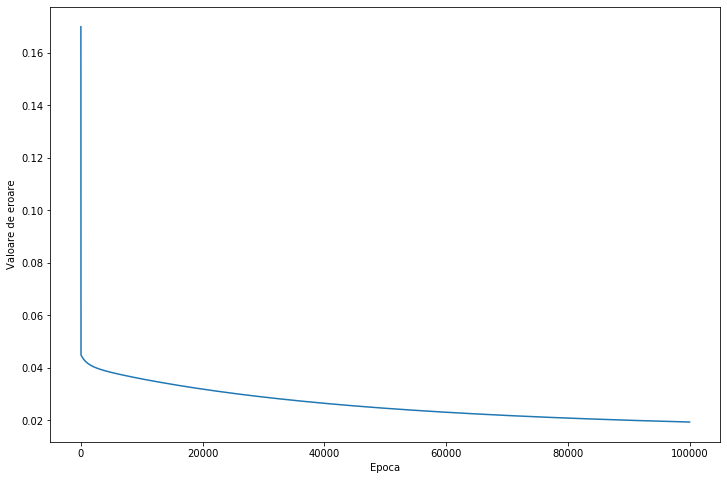

In [26]:
# desenarea curbei de cost pe setul de antrenare
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.xlabel('Epoca')
plt.ylabel('Valoare de eroare')
plt.plot(losses)

In [27]:
# Obtine valorile estimate de model, calculeaza eroarea intre estimare si 
# ground truth.

# estimare facuta de model
y_hat = np.vstack(np.sum(np.multiply(X, w.transpose()), axis=1))
# mean squared error pe setul de antrenare
error_sgd = mean_squared_error(y, y_hat)

print('Eroarea determinata prin algoritmul stochastic gradient descent:', error_sgd)
print('Vectorul de ponderi:', w[:, 0])

Eroarea determinata prin algoritmul stochastic gradient descent: 0.03395724293502481
Vectorul de ponderi: [  0.22495979   0.40494616   0.24364134  11.43391956   2.76308218
   1.31925777  -3.09057549  -3.09057549  -1.41875864   0.22495979
   0.75250165   3.8126903    0.22495979 -19.41768983   4.91275509
   0.14395485   0.80070499]


### Pseudoinverse method

In [28]:
# se calculeaza w cu metoda pseudoinversei 
w_pinv = np.matmul(np.linalg.pinv(X), y)

# se calculeaza estimarea data cu ponderile w_pinv
y_hat_pinv = h(X, w_pinv)

# se calculeaza eroarea patratica medie
error_pinv = mean_squared_error(y, y_hat_pinv)

print('Eroarea determinata prin metoda pseudoinversei:', error_pinv)

Eroarea determinata prin metoda pseudoinversei: 0.008010137201200612


In [29]:
print(np.linalg.norm(gradient(X, w_pinv, y)))

1.73935464161066e-14


In [30]:
# afiseaza ponderile determinate prin metoda pseudoinversei

print(w_pinv[:, 0])

[  0.29015495   0.39839967   5.56767682  40.06318117   5.89697855
   4.03988449 -20.25484653 -20.25484653 -18.34254684   0.29015495
   1.81835155  11.32697686   0.29015495 -37.23147039   1.22929938
  -0.88382777  25.32182337]


## Split validation

In [31]:
# imparte setul initial in 70% antrenare si 30% testare

np.random.shuffle(data)
split_percentage = 0.7
split_index = int(round(0.7 * (data.shape[0])))
data_train = data[0:split_index]
data_test = data[split_index+1:]
X_train, y_train = data_train[:, :-1], data_train[:, -1].reshape(-1, 1)
X_test, y_test = data_test[:, :-1], data_test[:, -1].reshape(-1, 1)

In [32]:
# scaleaza datele de intrare din setul de antrenare si obtine minimele 
# si maximele pe coloane
X_train, min_X_train, max_X_train = scale_matrix(X_train)
# scaleaza datele de iesire din setul de antrenare si obtine minimul si 
# maximul pe coloana
y_train, min_y_train, max_y_train = scale_matrix(y_train)

In [33]:
# scaleaza datele de intrare din setul de test, folosind minimele si maximele 
# pe coloane aflate de la X_train
# se foloseste functia scale_matrix_with_known_minmax
X_test = scale_matrix_with_known_minmax(X_test, min_X_train, max_X_train)

# scaleaza datele de iesire din setul de test, folosind minimul si maximul 
# pe coloana aflate de la y_train
y_test = scale_matrix_with_known_minmax(y_test, min_y_train, max_y_train)

In [ ]:
# antreneaza linear regression pe setul de antrenare, obtine ponderile
# modelului

w_train, losses_train = train(X_train, y_train, max_iters=100000, alpha=0.3, lmbda=0.1)
# scrieti cod pentru antrenare pe X_train, y_train 
# restul parametrilor ca la apelul de antrenare de mai sus

Loss at iteration 0: 0.1703510653579124
Loss at iteration 1000: 0.04245535515431625
Loss at iteration 2000: 0.04101912111017098
Loss at iteration 3000: 0.04008766956027215
Loss at iteration 4000: 0.039364522287493396
Loss at iteration 5000: 0.03874411296709598
Loss at iteration 6000: 0.038181805407499846
Loss at iteration 7000: 0.03765653059077979
Loss at iteration 8000: 0.03715759228131278
Loss at iteration 9000: 0.03667923869228887
Loss at iteration 10000: 0.03621819804516174
Loss at iteration 11000: 0.03577248787093797
Loss at iteration 12000: 0.03534081564054727
Loss at iteration 13000: 0.03492226832345106
Loss at iteration 14000: 0.034516148168129104
Loss at iteration 15000: 0.0341218843421992
Loss at iteration 16000: 0.033738984640132946
Loss at iteration 17000: 0.03336700863989752
Loss at iteration 18000: 0.03300555246624886
Loss at iteration 19000: 0.032654239896673265
Loss at iteration 20000: 0.03231271696980798
Loss at iteration 21000: 0.031980648553061784
Loss at iteration 2

In [ ]:
# obtine estimarile date de model pe setul de testare

y_hat_test = h(X_test, w_train)
print('MSE pentru setul de testare:', mean_squared_error(y_test, y_hat_test))

Text(0, 0.5, 'Diferenta intre ground truth si valoarea estimata')

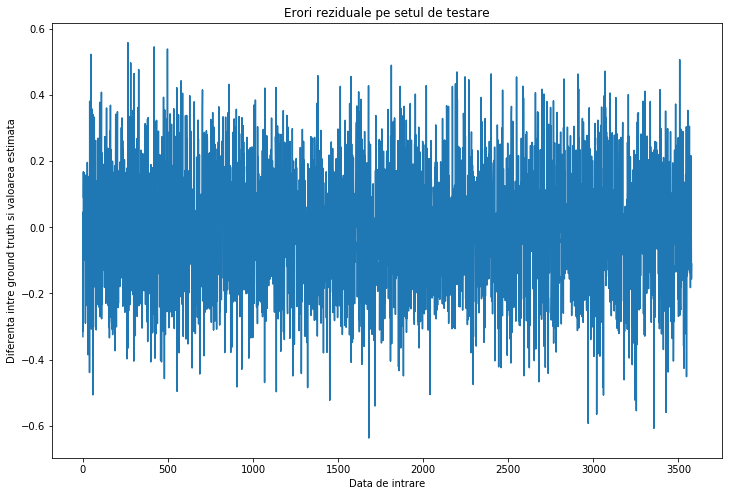

In [30]:
# reprezentarea diferentei intre ground truth si estimare pe setul de testare
plt.figure(figsize=(12, 8))
plt.title('Erori reziduale pe setul de testare')
plt.plot(y_test - y_hat_test)
plt.xlabel('Data de intrare')
plt.ylabel('Diferenta intre ground truth si valoarea estimata')